<a href="https://colab.research.google.com/github/Shrivastav-Gaurav/GenAI-ML-Notebook/blob/main/Training_LLMs_Class_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language. Chances are that your email program's spam filter is using text classification to protect your inbox from a deluge of unwanted junk!

In this problem, imagine that you are a machine learning engineer who needs to build a system that can automatically identify emotional states such as "anger" or "joy" that people express about your company's product on Twitter.

To do this, we are going follow the given steps:
- Pulling in the emotions data from the Hugging Face Hub begin exploring it using basic EDA methods.
- Afterwards, we'll gain some familiarity with Pytorch to tokenize the data and begin understanding the intricies of tokenization.
- Next we'll gain some familiarty with using LLM hidden states to predict sentiment. In this way we are going to use the output of the model to directly see how it can influence the emotion prediction.
- Lastly, we are going to fine tune a language model from scratch on the sentiment data as well as perform fine tuning using a LoRA implementation.


## The Dataset

To build our emotion detector we'll use a great dataset from an article that explored how emotions are represented in English Twitter messages. Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

We will use Datasets to download the data from the [Hugging Face Hub](https://huggingface.co/datasets). We can use the `list_datasets()` function to see what datasets are available on the Hub:

In [ ]:
!pip install datasets

In [ ]:
!pip install transformers[torch]==4.42.4

In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

If we look inside our `emotions` object:

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [ ]:
train_ds = emotions["train"]
train_ds

train_val = emotions["validation"]
train_val

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in image:images/logo.png[hf,13,13] Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [ ]:
len(train_ds)
len(train_val)

2000

or access a single example by its index:

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names and the values are the tweet and the emotion.

In [ ]:
train_ds.column_names

['text', 'label']

 We can see what data types are being used under the hood by accessing the `features` attribute of a `Dataset` object:

In [ ]:
print(train_ds.features)
print(train_val.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Pytorch Dataset to Pandas Dataframe

Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a `Dataset` object to a Pandas `DataFrame` so we can access high-level APIs for data visualization. To enable the conversion, Datasets provides a `set_format()` method that allows us to change the _output format_ of the `Dataset`. Note that this does not change the underlying _data format_ (which is an Arrow table), and you can switch to another format later if needed:

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

dfval = emotions["validation"][:]
dfval.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

dfval["label_name"] = dfval["label"].apply(label_int2str)
dfval.head()

,text,label,label_name
0,im feeling quite sad and sorry for myself but ...,0,sadness
1,i feel like i am still looking at a blank canv...,0,sadness
2,i feel like a faithful servant,2,love
3,i am just feeling cranky and blue,3,anger
4,i can have for a treat or if i am feeling festive,1,joy


### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

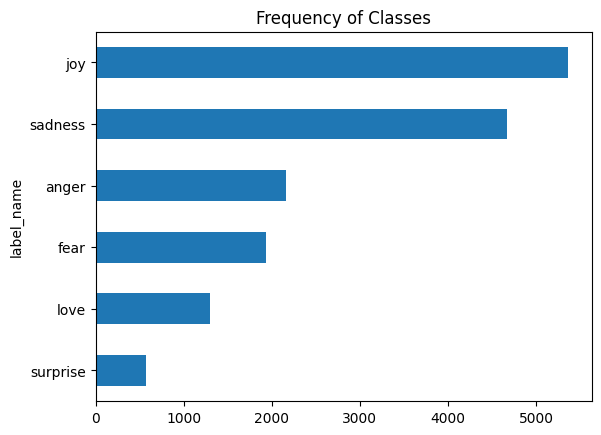

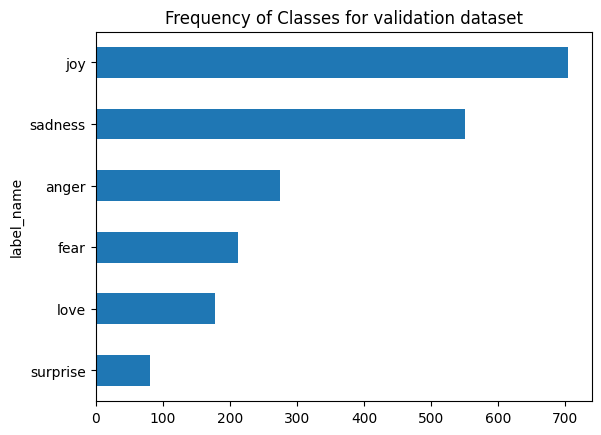

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

dfval["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes for validation dataset")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer.

Now that we've looked at the classes, let's take a look at the tweets themselves.

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

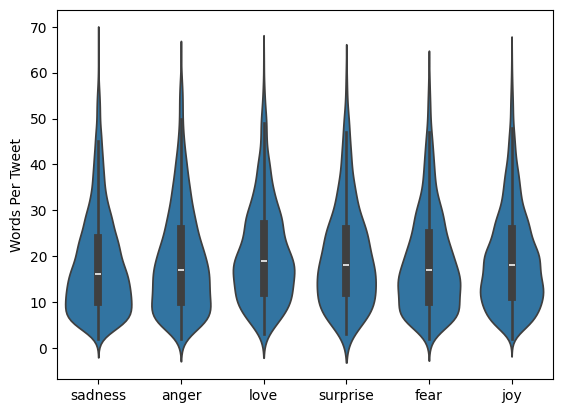

In [ ]:
import seaborn as sns
df["Words Per Tweet"] = df["text"].str.split().apply(len)
sns.violinplot(data=df, x ='label_name', y='Words Per Tweet')
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

Let's now figure out how we can convert these raw texts into a format suitable for Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the `DataFrame` format anymore:

In [ ]:
emotions.reset_format()

## From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been _tokenized_ and _encoded_ as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: _character_ and _word_ tokenization.

### Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model. In Python, `str` objects are really arrays under the hood, which allows us to quickly implement character-level tokenization with just one line of code:

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start, but we're not done yet. Our model expects each character to be  converted to an integer, a process sometimes called _numericalization_. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use `token2idx` to transform the tokenized text to a list of integers:

In [ ]:
#Each character in tokenized_text is replaced with its corresponding index from the token2idx dictionary.
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [ ]:
## word tokenization
import nltk
from nltk import word_tokenize, TweetTokenizer
nltk.download('punkt')

text = "Tokenizing text is a core task of NLP :D."
# tokenized_text = word_tokenize(text)
tokenized_text = TweetTokenizer().tokenize(text)
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP', ':D', '.']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


From our simple example we can see that character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be _learned_ from the data. This requires significant compute, memory, and data. For this reason, character tokenization is rarely used in practice. Instead, some structure of the text is preserved during the tokenization step. _Word tokenization_ is a straightforward approach to achieve this, so let's take a look at how it works.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. Transformers provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [ ]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

> note: When you run the `AutoTokenizer.from_pretrained()` method for the first time you will see a progress bar that shows which parameters of the pretrained tokenizer are loaded from the Hugging Face Hub. When you run the code a second time, it will load the tokenizer from the cache, usually located at _~/.cache/huggingface/_.

Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1024, 1040, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', ':', 'd', '.', '[SEP]']


We can observe three things here. First, some special `[CLS]` and `[SEP]` tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The `##` prefix in `##izing` and `##p` means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The `AutoTokenizer` class has a `convert_tokens_to_string()` method for doing just that, so let's apply it to our tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp : d. [SEP]


The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [ ]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [ ]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

When using pretrained models, it is _really_ important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [ ]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input.


Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


> Note: In later chapters, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

In [ ]:
ds_fake = emotions_encoded.copy()
ds_fake['train'].set_format(type='pandas')
ds_fake = ds_fake['train'][:]
ds_fake.sample(8)

,text,label,input_ids,attention_mask
10784,i suppose to feel terrified,4,"[101, 1045, 6814, 2000, 2514, 10215, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1864,i saw a few pianos that were either newer chea...,4,"[101, 1045, 2387, 1037, 2261, 27864, 2008, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3600,i dont hate you i just honestly feel so bitter...,3,"[101, 1045, 2123, 2102, 5223, 2017, 1045, 2074...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3317,i feel that sweet potatoes are very under rated,2,"[101, 1045, 2514, 2008, 4086, 14629, 2024, 220...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
9190,i dint feel any strong pain yet just cramping ...,1,"[101, 1045, 11586, 2102, 2514, 2151, 2844, 325...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8421,im feeling a need to revisit my artistic influ...,1,"[101, 10047, 3110, 1037, 2342, 2000, 7065, 174...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
704,i feel like a greedy little traitor i m lookin...,3,"[101, 1045, 2514, 2066, 1037, 20505, 2210, 173...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
14719,i feel sad donna summer dead at a href http jtwoo,0,"[101, 1045, 2514, 6517, 10972, 2621, 2757, 201...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


Before we train our classifier, let's go ahead and get the labels of our dataset and store them in a variable. They'll be needed for later on.

In [ ]:
labels = emotions["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

## Training a Text Classifier

First, the text is tokenized and represented as one-hot vectors called _token encodings_. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings are converted to _token embeddings_, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a _hidden state_ for each input token. For the pretraining objective of language modeling,&#x2060; footnote:[In the case of DistilBERT, it's guessing the masked tokens.] each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

We have two options to train such a model on our Twitter dataset:

- _Feature extraction_:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- _Fine-tuning_:: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In the following sections we explore both options for DistilBERT and examine their trade-offs.

### Transformers as Feature Extractors


Using a transformer as a feature extractor is fairly simple. We freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

#### Using pretrained models


We will use another convenient auto class from Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [ ]:
# hide_output
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

To warm up, let's retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the `return_tensors="pt"` argument to the tokenizer as follows:

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
# tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

Input tensor shape: torch.Size([1, 6])


As we can see, the resulting tensor has the shape `[batch_size, n_tokens]`. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [ ]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [ ]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
# print(outputs)
outputs[0]#.shape

tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0')

Here we've used the `torch.no_grad()` context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a `namedtuple` in Python. In our example, the model output is an instance of `BaseModelOutput`, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape `[batch_size, n_tokens, hidden_dim]`. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into `outputs.last_hidden_state` as follows:

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now that we know how to get the last hidden state for a single string, let's do the same thing for the whole dataset by creating a new `hidden_state` column that stores all these vectors. As we did with the tokenizer, we'll use the `map()` method of `DatasetDict` to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The `map()` method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the `input_ids` and `attention_mask` columns to the `"torch"` format, as follows:

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

We can then go ahead and extract the hidden states across all splits in one go:

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Note that we did not set `batch_size=None` in this case, so the default `batch_size=1000` is used instead. As expected, applying the `extract_hidden_states()` function has added a new `hidden_state` column to our dataset:

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix - let's take a look.

#### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-Learn format as follows:

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
X_train.shape

(16000, 768)

Before we train a model on the hidden states, it's good practice to perform a sanity check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we'll see how visualizing the features provides a fast way to achieve this.

#### Training a simple classifier


We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [ ]:
#hide_output
# We increase `max_iter` to guarantee convergence
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=300)
lr_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.623

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

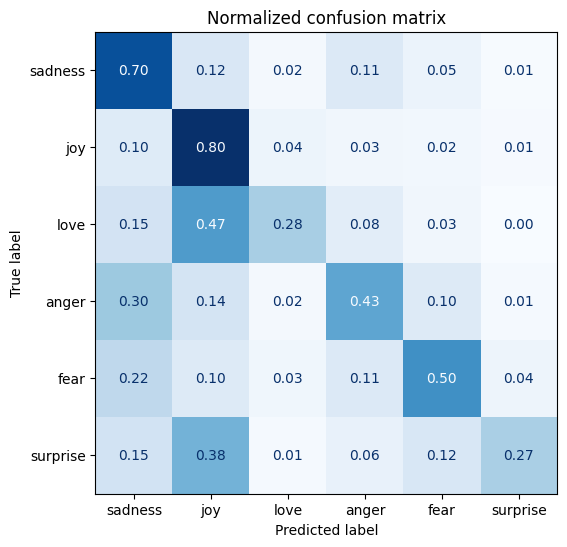

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that `anger` and `fear` are most often confused with `sadness`. Also, `love` and `surprise` are frequently mistaken for `joy`.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead allow all parameters to be trainable. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API from HF Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error",
                                  report_to="none")
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.829300,0.303734,0.908500,0.908112
2,0.243700,0.214944,0.925500,0.925529


Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`:

Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [ ]:
preds_output.metrics

{'test_loss': 0.21494393050670624,
 'test_accuracy': 0.9255,
 'test_f1': 0.9255291268537333,
 'test_runtime': 3.8005,
 'test_samples_per_second': 526.247,
 'test_steps_per_second': 8.42}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

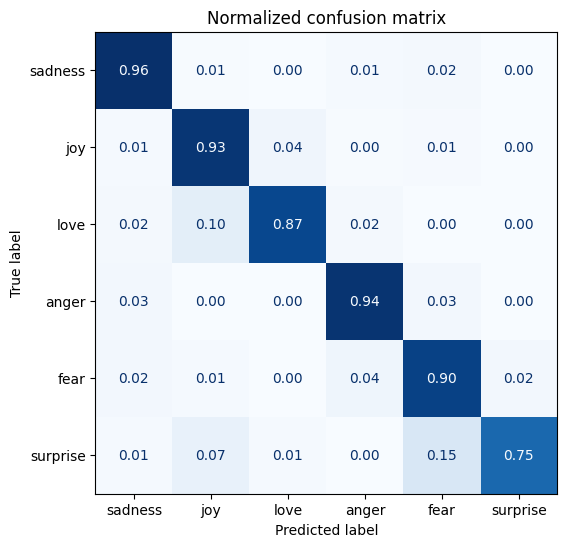

In [ ]:
    plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

## Use LoRa to fine tune a model

Often times, fine tuning a model can be a very daunting task especially with the amount of data and parameters that these large language models can have. At this point, we want to discuss the method of LoRA and discover how we can implement it in Python to avoid these issues.

We are going to perform the same tweet classification problem but instead of using an off the shelf Distilled Bert Model, we are going to use the larger BERT model combined with LoRA. From there we can examine the performances of the two models and see how they perform comparatively.

In [ ]:
# !pip install git+https://github.com/huggingface/peft
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
# let us now get the LoRA confirguration
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=32, lora_alpha=1, lora_dropout=0.1, target_modules=[
        "q_lin",
        "k_lin",
        "v_lin"]
)


In [ ]:
#print(model)

In [ ]:
# load in the LoRA model and
# wrap it around the BERT model
from peft import get_peft_model
lora_model = get_peft_model(model, lora_config)

In [ ]:
#print(lora_model)

In [ ]:
# check the number of parameters
sum(p.numel() for p in lora_model.parameters())

68438028

In [ ]:
# perform the exact same training loop as before
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"lora-bert-base-uncased-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, #True
                                  log_level="error",
                                  report_to="none")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# fine tune the model
trainer = Trainer(model=lora_model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.179100,0.200718,0.925000,0.925333
2,0.168100,0.200864,0.924000,0.924338


In [ ]:
# evaluate the model
trainer.evaluate()

{'eval_loss': 0.20086419582366943,
 'eval_accuracy': 0.924,
 'eval_f1': 0.9243376826743993,
 'eval_runtime': 4.1822,
 'eval_samples_per_second': 478.217,
 'eval_steps_per_second': 7.651,
 'epoch': 2.0}

In [ ]:
# get the predictions as before
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
# check metrics
preds_output.metrics

{'test_loss': 0.20086419582366943,
 'test_accuracy': 0.924,
 'test_f1': 0.9243376826743993,
 'test_runtime': 4.0557,
 'test_samples_per_second': 493.135,
 'test_steps_per_second': 7.89}

In [ ]:
# get the predictions in the same format
# as before
y_preds = np.argmax(preds_output.predictions, axis=1)

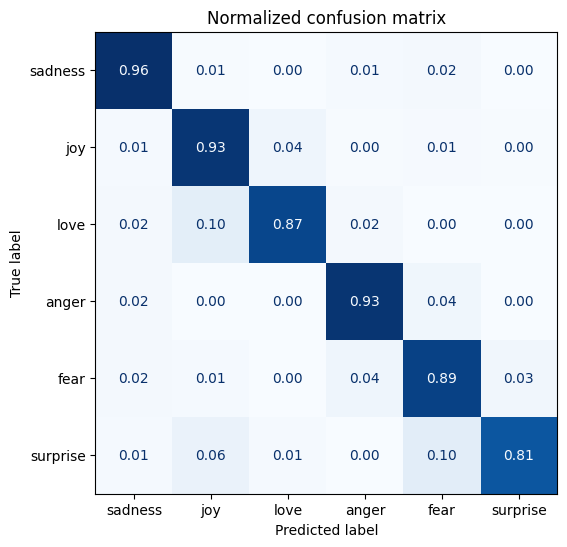

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(y_preds, y_valid, labels)

At this point we can see that the LoRA model performs in a similar manner but training time was a bit shorter. Moreover, the number of parameters that we updated was considerably smaller resulting in much less resources being used for training. This is a huge benefit of implementing a LoRA fine tuning method.